In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./src') 
from xgboost_utils import train_xgb
from xgboost_predictor import generate_sparse_pgv

## Step 1: Train XGBoost Models and Generate Sparse Maps

1- We train one XGBoost model per receiver  


Training R²: 0.9302
Test R²: 0.8886


Text(0, 0.5, 'Predicted log(PGV) (mm/s)')

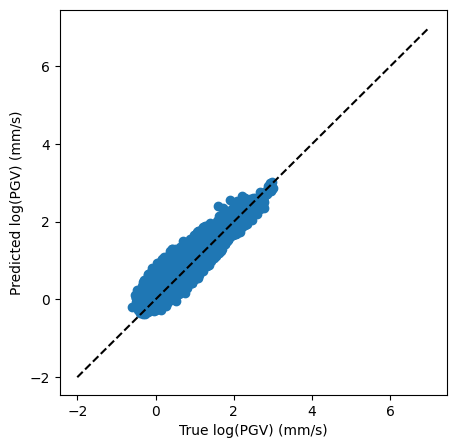

In [6]:
# load input and output data for receiver
receiver_idx         = 139   # choose a receiver index from 0 to 255
receiver_database    = np.load(f'data/reciprocal_db/receiver_{receiver_idx}_database.npz')
inputs  = receiver_database['inputs']   # source coords and mechanism ([distance, azimuth, depth, strike, dip, rake, radiation, takeoff] )
outputs = receiver_database['outputs']  # pgv along two components (East-West, North-South) in mm/s

# train xgboost model 
pgv_true, pgv_pred = train_xgb(inputs, np.log(outputs[:,0]))  
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pgv_true, pgv_pred)
ax.plot([-2, 7], [-2, 7], 'k--')
ax.set_xlabel('True log(PGV) (mm/s)')
ax.set_ylabel('Predicted log(PGV) (mm/s)')

In [20]:
(5*50+2*256) * 51

38862

In [4]:
10/70

0.14285714285714285

In [2]:
20/70

0.2857142857142857

In [ ]:
0.2

In [13]:
M0 = (1/np.sqrt(2)) * (1e+14)
Mw = (2/3) * (np.log10(M0) - 9.1)
print(f'Mw = {Mw:.1f}')

Mw = 3.2


Training R²: 0.9307
Test R²: 0.8903


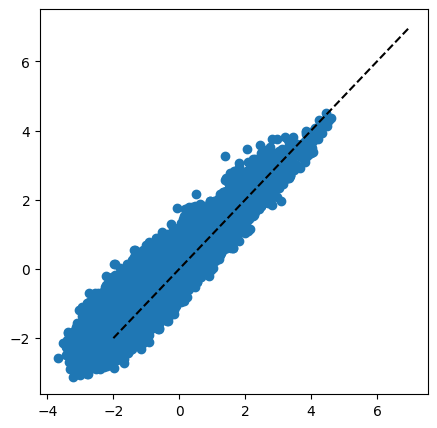

In [8]:
# load input and output data for receiver
receiver_idx         = 139   # choose a receiver index from 0 to 255
receiver_database    = np.load(f'data/reciprocal_db/receiver_{receiver_idx}_database.npz')
inputs  = receiver_database['inputs']   # source coords and mechanism ([distance, azimuth, depth, strike, dip, rake, radiation, takeoff] )
outputs = receiver_database['outputs']/10  # pgv along two components (East-West, North-South) in mm/s

# train xgboost model 
pgv_true, pgv_pred = train_xgb(inputs, np.log(outputs[:,0]))  
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pgv_true, pgv_pred)
ax.plot([-2, 7], [-2, 7], 'k--')
#ax.set_xlabel('True log(PGV) (mm/s)')
#ax.set_ylabel('Predicted log(PGV) (mm/s)')

In [2]:
import numpy as np  
test_ids = np.load('results/20251005_144124_b7bb84/test_ids.npy')
test_ids.shape

(1000,)

2- We repeat the process above for all the receivers. The trained models for each receiver 
and for each of the components (East and North) are stored in the `models/` directory. 

3 - We use the trained XGBoost models to generate sparse PGV maps for the forward simulations (used as input for Step 2) 

In [ ]:
# generate a sparse PGV map for input source coordinates and focal mechanism
# we show an example of generating sparse maps for a database with 50 source locations, and 50 mechanims per location refered to as 50_50

data_tag   = '50_50'  
models_dir = '/media/wolf6819/Elements/PGVnet/data/xgb_models'
spacing_km = 4 
station_coords_path = '/media/wolf6819/Elements/PGVnet/data/receiver_coords_sparse.npz' 
output_path         = '/media/wolf6819/Elements/PGVnet/data/step1_preds'

sparse_maps = generate_sparse_pgv(station_coords_path, models_dir, output_path, data_tag, spacing_km)

In [ ]:
# an example of a sparse PGV map  
station_coords_file = '/media/wolf6819/Elements/PGVnet/data/receiver_coords_sparse.npz'  
station_coords       = np.load(station_coords_file)['station_coords']

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(station_coords[:,0]/1e3, station_coords[:,1]/1e3, c = sparse_maps[0,:,:,0], s=100, cmap='plasma')
ax.set_xlabel('East Distance (km)') 
ax.set_ylabel('North Distance (km)')    

## Step 2: Train the Encoder-MLP on Sparse Maps

We use the predicted sparse maps to train an EncoderMLP network 


In [ ]:
from types import SimpleNamespace
from encoderMLP_predictor import run_train  

# Manual config 
config = SimpleNamespace(
  
    mode              = "train",
    data_tag          = "50_50_x4",
    downsample_factor = 4,
    
    # additional defaults 
    data_dir="data/",
    transform_input=True,
    transform_output=True,
    inc_gradient=False,
    inc_distance=True,
    normalize_output=True,
    normalize_input=True,
    nx_patch=8,
    ny_patch=8,
    fourier_features=False,
    D=32,
    gamma=5.0,
    n_samp_pts_per_patch=512,
    split=0.8,
    batch_size=32,
    learning_rate=1e-3,
    loss_type="mse",
    optimizer="adamw",
    num_epochs=1, 
    enc_type="edsr",
    in_channels=5,
    out_channels=32,
    conv_kernel_size=3,
    attention_kernel_size=1,
    num_features=32,
    num_blocks=8,
    nf=32,
    activation="leaky_relu",
    pad_size=4,
    sigma=3.0,
    results_dir=None,
    stats_tag=None
)

# Run training
run_train(config)


Next, we test the trained network on an independent set of test events, the results are stored in the relevant dir in the `./results` folder

In [ ]:
import yaml
from encoderMLP_predictor import run_test
from types import SimpleNamespace

with open("results/results_70_50/config.yaml", "r") as f:
    cfg_dict = yaml.safe_load(f)

config             = SimpleNamespace(**cfg_dict)
config.mode        = "test"
config.results_dir = "results/results_70_50"

# Run testing
run_test(config)

We show an example of the true (simulated) vs predicted PGV maps 

In [ ]:
preds = np.load('results/results_70_50/test_preds.npy')
gts   = np.load('results/results_70_50/test_gts.npy')  


# choose a random idx between 0 and the number of samples in preds  
idx  = np.random.randint(0, preds.shape[0])
comp = 1  # choose component 0 (East-West) or 1 (North-South)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  
pred = preds[idx,:,:,comp]/10  # predicted PGV    
gt   = gts[idx,:,:,comp]/10    # true PGV
norm = plt.Normalize(vmin=0, vmax=np.max(gt)) 

cf0 = ax[0].contourf(gt, cmap='plasma', norm=norm)
cf1 = ax[1].contourf(pred, cmap='plasma', norm=norm)

ax[0].set_title('True PGV')    
ax[1].set_title('Predicted PGV')
ax[0].set_xlabel('East Distance (km)')  
ax[0].set_ylabel('North Distance (km)') 
ax[1].set_xlabel('East Distance (km)')  

fig.subplots_adjust(right=0.85)  
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7]) 
fig.colorbar(cf1, cax=cbar_ax, norm = norm).set_label("PGV (cm/s)", fontsize=14)
# add text to both subplots with max pgv in each 
ax[0].text(0.05, 0.1, f'Max PGV: {np.max(gt):.2f} cm/s', transform=ax[0].transAxes,fontsize=12,verticalalignment='top',
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
ax[1].text(0.05, 0.1, f'Max PGV: {np.max(pred):.2f} cm/s', transform=ax[1].transAxes, fontsize=12, verticalalignment='top',
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    

In [ ]:
test_ids = np.load('/media/wolf6819/Elements/PGVnet/results/results_70_50/test_ids.npy')
print(test_ids.shape)

pgv_hres = np.load('/media/wolf6819/Elements/PGVnet/data/forward_db/pgv_database_70_50_x4.npz')['pgv_hres']
print(pgv_hres.shape)

source_params = np.load('/media/wolf6819/Elements/PGVnet/data/forward_db/source_params_70_50.npz')['source_params']
print(source_params.shape)

In [ ]:
source_params_test = source_params[test_ids]    
print(source_params_test.shape) 

plt.scatter(source_params_test[:,0], source_params_test[:,1])
# make aspect ratio 1:1 
plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
test_ids.shape

In [ ]:
source_params = np.load('data/forward_db/source_params_70_50.npz')['source_params']
test_ids      = np.load('results/results_70_50/test_ids.npy')  

error = np.abs(preds - gts)
mean_error = np.mean(error, axis =(1, 2, 3))  # mean error across spatial dimensions
print(mean_error.shape)
params = source_params[test_ids]
print(params.shape)
# change the first two parameters to East and North distance in km
params[:, 0] /= 1000  # East Distance in km
params[:, 1] /= 1000  # North Distance in km
params[:, 2] /= 1000  # Depth in km 
param_names = ["East Distance (km)", "North Distance (km)", "Depth (km)", "Strike (°)", "Dip (°)", "Rake (°)"]  # replace with your actual names

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < params.shape[1]:
        ax.scatter(params[:, i], mean_error/10, s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
        ax.set_xlabel(param_names[i])
        if i % 3 == 0:
            ax.set_ylabel("Mean Absolute Error (cm/s)")
            
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_ylim(0, 0.35)  #
        ax.set_yticks(np.arange(0, 0.35, 0.1))
    else:
        ax.axis('off')  
        ax.locator_params(axis='x', nbins=5)  
        ax.locator_params(axis='y', nbins=5) 

# set axis for the first two subplots 
axes[0, 0].set_xlim(-25, 25)  # East Distance (km)    
axes[0, 1].set_xlim(-25, 25)  # North Distance (km)   
fig.tight_layout(rect=[0, 0, 1, 0.95])